In [1]:
from Bio import SeqIO
from glob import glob
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import copy 

In [3]:
import numpy as np
np.__version__

'1.22.3'

In [4]:
from genotyping import *

In [5]:
def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)


## Load reference

In [6]:
# Path to reference genome
reference_path = '../../../data/reference/mito_GRCh38_gimlet.fasta'

with open(reference_path, 'r'):
    reference_seq = next(SeqIO.parse(reference_path, "fasta"))
reference = pd.Series(list(reference_seq.seq))

## Load read matrices

In [60]:
# Get current date
today = datetime.date.today()

# Format date as a string in the format "YYYY_M_D"
date_string = today.strftime("%Y_%-m_%-d")

# Path to allele count files
#INPUT_PATH = '/home/carler/lab/t_cell/phylogeny/data/ac_input'
INPUT_PATH = '/home/carler/lab/t_cell/phylogeny/data/ac_input/'
CLUST_MUTATION = 0
OUTPUT_PATH = f'/home/carler/lab/t_cell/phylogeny/data/output/P20407/{date_string}_pmat_clust_mutations_{CLUST_MUTATION}/'
create_directory(OUTPUT_PATH)

In [61]:
datasets = ['A1_06', 'A1_30']#, 'YFV2003', 'JH']

In [62]:
#meta = pd.read_csv('/home/carler/lab/t_cell/phylogeny/data/P20407/a1_06_meta_data.csv', names=['cell_id', 'clone_id'])
#clone_sizes_n_10 = pd.DataFrame(meta.groupby('clone_id').count()) 
#clone_sizes_n_10 = clone_sizes_n_10.loc[clone_sizes_n_10['cell_id'] >=10].index
#meta = meta.loc[meta['clone_id'].isin(clone_sizes_n_10)].set_index('cell_id')

In [63]:
#meta.loc[name]

In [65]:
donor_dict = {'A1_06' : None,
              'A1_30' : None, 
              'YFV2003': None, 
              'JH': None}

In [66]:
qc_passed_cells_a6 = pd.read_csv('/home/carler/lab/t_cell/meta_data/mem_eff_score/a1_06_mem_eff.csv', index_col=0)
qc_passed_cells_a30 = pd.read_csv('/home/carler/lab/t_cell/meta_data/mem_eff_score/a1_30_mem_eff.csv', index_col=0)


In [67]:
all_qc = list(qc_passed_cells_a30.index) + list(qc_passed_cells_a6.index)

In [68]:
meta_data = pd.read_csv('/home/carler/lab/t_cell/meta_data/2023_04_06_A1_06_A1_30_YFV2003_JH_meta_data_invivo_t_cell_mito_project.csv', index_col=0)
meta_data = meta_data.loc[all_qc]
clone_n_10 = meta_data.groupby('clone_id')['Donor'].count()
clone_n_10 = pd.DataFrame(clone_n_10[clone_n_10 >= 6]) 
meta_data_clone_n_10 = meta_data.loc[meta_data['clone_id'].isin(clone_n_10.loc[clone_n_10.index.str[1] != '-'].sort_values('Donor').index)] 
cell_count = {'A1_06' : [],
              'A1_30' : [], 
              'YFV2003': [], 
              'JH': []}

# Get all allele counts files in the input path
cell_count_filenames = list(glob(os.path.join(INPUT_PATH, '*.t*'))) #*.txt/.tsv




sample_list = {'A1_06' : [],
              'A1_30' : [], 
              'YFV2003': [], 
              'JH': []}

#for filename in sorted(cell_count_filenames):
#    name = os.path.basename(filename).split('-')[0]#.split('_')[-1]
#    sample_list.append(name)




for filename in sorted(cell_count_filenames):
    #print('Reading {}'.format(filename))
    name = os.path.basename(filename).split('.')[0]
    
    if  name not in meta_data_clone_n_10.index: 
        continue
    
    # Load one allele count file
    counts = pd.read_csv(filename, sep='\t')
    counts = pd.DataFrame(index=range(1, 16572, 1), columns=['#CHR', 'Count_A', 'Count_C', 'Count_G', 'Count_T', 'Good_depth']).combine_first(counts.set_index('POS')).fillna(0)
    counts[['Count_A', 'Count_C', 'Count_G', 'Count_T', 'Good_depth']] = counts[['Count_A', 'Count_C', 'Count_G', 'Count_T', 'Good_depth']].astype(int)
    counts.index.name = 'POS'
    counts = counts.reset_index()
    counts.name = name
    try: 
        cell_count[meta_data_clone_n_10.loc[name].Donor].append(counts)
        sample_list[meta_data_clone_n_10.loc[name].Donor].append(name)
    except KeyError: 
        continue

# Get sample order
'''
sample_list = {'A1_06' : [],
              'A1_30' : [], 
              'YFV2003': [], 
              'JH': []}

for filename in sorted(cell_count_filenames):
    name = os.path.basename(filename).split('-')[0]#.split('_')[-1]
    sample_list[meta_data.loc[name[:-4]].Donor].append(name)

sample_list_df = {'A1_06' : [],
              'A1_30' : [], 
              'YFV2003': [], 
              'JH': []}

for donor in datasets: 
    sample_list_df[donor] = pd.DataFrame(sample_list[donor])
    sample_list_df[donor] = sample_list_df[donor].rename(columns={0: 'cell'})'''

"\nsample_list = {'A1_06' : [],\n              'A1_30' : [], \n              'YFV2003': [], \n              'JH': []}\n\nfor filename in sorted(cell_count_filenames):\n    name = os.path.basename(filename).split('-')[0]#.split('_')[-1]\n    sample_list[meta_data.loc[name[:-4]].Donor].append(name)\n\nsample_list_df = {'A1_06' : [],\n              'A1_30' : [], \n              'YFV2003': [], \n              'JH': []}\n\nfor donor in datasets: \n    sample_list_df[donor] = pd.DataFrame(sample_list[donor])\n    sample_list_df[donor] = sample_list_df[donor].rename(columns={0: 'cell'})"

In [69]:
def remove_low_cov_pos(cell_count):
    
    # Filter positions with low mean coverage
    
    # First make list with positions with low coverage
    # concat cell counts into new df
    cc_flt = pd.concat(cell_count, axis=1)
    # drop unwanted cols
    cc_flt.drop(['#CHR', 'POS', 'Count_A', 'Count_C', 'Count_G', 'Count_T'], axis=1, inplace=True)
    # drop bulk col
    column_numbers = [x for x in range(cc_flt.shape[1])] # list of columns' integer indices
    column_numbers.remove(0) #removing column integer index 0
    cc_flt = cc_flt.iloc[:, column_numbers] #return all columns except the 0th column
    
    # compute average coverage
    cc_flt['mean'] = cc_flt.mean(axis=1)
    
    # Get positions in new col
    cc_flt.reset_index(inplace=True)
    cc_flt['POS'] = cc_flt['index']+1
    
    # make new df with only relevant info
    cc_flt_pos = cc_flt[['mean', 'POS']]
    
    # reset index
    cc_flt_pos.set_index('POS', inplace=True)
    
    # Select rows with low coverage
    threshold = 100
    below_thres = cc_flt_pos.loc[cc_flt_pos['mean'] < threshold]

    # save index (which is POS) to list
    below_thres_lst = below_thres.index.tolist()
    
    return below_thres_lst

In [70]:
# Obtain a set of error rates to test


e_rates = [0.0001 ,0.0112 ,0.0223 ,0.0334 ,0.0445 ,0.0556 ,0.0667 ,0.0778,0.0889 ,0.1 ,0.2 ,0.22]
e_rates = [0.0556]

#e_rates = np.linspace(0.0001, 0.0009, 10).round(4)
#extra_error_rates = [0.001, 0.002, 0.005]
#extra_error_rates_ar = np.array(extra_error_rates)
#all_e_rates = np.concatenate((e_rates1, extra_error_rates_ar))

all_e_rates = e_rates
all_e_rates

[0.0556]

In [71]:
len(sample_list['A1_06'])

1526

In [72]:
#np.linspace(0.0001, 0.22, 10).round(4)

## Compute mutations probabilities

In [73]:
def cell_prob(e_rate, cell_count):
    
    error_rate_when_no_mutation = error_rate_when_mutation = e_rate
    p_mutation = 1 / 500.0

    cell_prob = []
    for count in cell_count:
        count = count.iloc[:reference.shape[0]]  # discard trailing positions
        p = nucleotide_mutation_prob(
            cell_counts=count,
            reference=reference,
            error_rate_when_no_mutation=error_rate_when_no_mutation,
            error_rate_when_mutation=error_rate_when_mutation,
            p_mutation=p_mutation,
        )

        cell_prob.append(p)
        
    # Compute P(mutation | read counts)
    cells_p_mutation = []
    for cell_prob in cell_prob:
        p = mutation_prob(cell_prob, reference)
        cells_p_mutation.append(p)
        
        
    # Make mutation matrix
    mutation_matrix = cells_p_mutation[0][['#CHR', 'POS']].copy()
    mutation_matrix_data = pd.DataFrame(np.dstack([c['Prob_mutation'].values for c in cells_p_mutation]).squeeze())
    mutation_matrix = pd.concat([mutation_matrix, mutation_matrix_data], axis=1)
    return mutation_matrix      

## Filter pmat

In [74]:
def flt_pmat(e_rate, cell_count, donor):
    mutation_matrix = cell_prob(e_rate, cell_count)

    print(f'no filters {mutation_matrix.shape}')
    # Remove germline mutations
    #mutation_matrix = mutation_matrix.loc[mutation_matrix[0] < 0.9]
    
    # Probabilities for location with mutation at any of the cells
    mutation_threshold = 0.9
    data = mutation_matrix.set_index('POS').drop('#CHR', axis=1)
    mutation_any_cell = data[(data > mutation_threshold).any(axis=1)]
    
    # select rows that have a value greater than mutation_threshold in more than x cells
    mutation_threshold = 0.9
    mask = (data.values > mutation_threshold).sum(axis=1) > 1 #create an array with boolean values and sum these along the axis and select rows with more than 1 True
    two_cells_have_mut = data[mask]

    # Define size of 50% of the population
    half = len(two_cells_have_mut.columns) / 2

    # Remove rows where 50% of cols are nan and save in new df
    nan_rows = two_cells_have_mut.drop(two_cells_have_mut[(two_cells_have_mut.isna()).sum(axis=1)> half].index)
    
    print(f"remove rows where 50% is nan {nan_rows.shape}")

    percentage_exceeding_09 = (nan_rows > 0.9).sum(axis=1) / nan_rows.shape[1]
    no_germline = nan_rows[percentage_exceeding_09 <= 0.4]

    print(f"remove rows where 40% positions is above 90% probablity {no_germline.shape}")

    # Replace NaN with row mean
    imputed = no_germline.transpose().fillna(no_germline.mean(axis=1)).transpose()
    
    # To skip removal of sites with overall high probability for mut
    #high_prob_rows = imputed.copy()
    
    # remove locations close to another location
    index = imputed.index.tolist() + [2000000]
    ind = [ a for a,b in zip(index[:-1], index[1:]) if b-a > CLUST_MUTATION]
    clust = imputed.loc[ind]
    #clust.shape
    print(f'remove cluster mutations {clust.shape}')
    
    # Replace 1.0
    replaced = clust.replace(1.0, 0.99999)
        
    # Remove pos with low cov
    below_thres_lst = remove_low_cov_pos(cell_count)
    
    low_dp = replaced.copy()
    low_dp.reset_index(inplace = True)
    low_dp = low_dp[~low_dp['POS'].isin(below_thres_lst)]
    low_dp.set_index('POS', inplace=True)
    print(f"remove positions with low dp {low_dp.shape}")
    # save matrix
    np.set_printoptions(suppress=True)
    e_rate_name = str(e_rate)
    matrix_path = OUTPUT_PATH + e_rate_name + '_'  + donor + '.csv'
    low_dp.to_csv(matrix_path, index=False, sep=' ', header= False)
    pd.DataFrame(index=low_dp.index, columns=sample_list[donor]).to_csv(OUTPUT_PATH + e_rate_name + '_' + donor + '_samples_meta_data.csv', index=True, header=True)
    return low_dp
    


In [75]:
low_dp =  copy.deepcopy(donor_dict)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
for donor in datasets:
    print(donor)
    for e_rate in all_e_rates:
        print(e_rate)
        low_dp[donor] = flt_pmat(e_rate, cell_count[donor], donor)  

A1_06
0.0556
no filters (16569, 1528)
remove rows where 50% is nan (737, 1526)
remove rows where 40% positions is above 90% probablity (719, 1526)
remove cluster mutations (719, 1526)
remove positions with low dp (567, 1526)
A1_30
0.0556
no filters (16569, 1171)
remove rows where 50% is nan (742, 1169)
remove rows where 40% positions is above 90% probablity (728, 1169)
remove cluster mutations (728, 1169)
remove positions with low dp (577, 1169)


In [43]:
low_dp_copy = low_dp.copy()

## Now run mt-SCITE

In [44]:
low_dp = low_dp_copy.copy()

In [45]:
col_labels = donor_dict.copy()
clones_map = donor_dict.copy()

for donor in datasets: 
    col_labels[donor] = []
    for cell in sample_list[donor]: 
        col_labels[donor].append(cell)
    
    clones_map[donor] = pd.DataFrame(meta_data.loc[sample_list[donor]].clone_id)
    clones_map[donor].clone_id = clones_map[donor].clone_id.str[1:].astype(int)
    low_dp[donor].set_axis(col_labels[donor], axis=1, inplace=True)
    

In [46]:
cells_with_mutation_at_pos = donor_dict.copy()
for donor in datasets:
    cells_with_mutation_at_pos[donor] = []
    cells_with_mutation_at_pos[donor] = (low_dp[donor] > 0.2)

In [47]:
cols_to_clones = donor_dict.copy()
clones_with_mutation_at_pos = donor_dict.copy()
for donor in datasets: 
    #cols_to_clones[donor] = pd.DataFrame()
    cols_to_clones[donor] = low_dp[donor].columns.map(clones_map[donor]['clone_id'])
    clones_with_mutation_at_pos[donor] = cells_with_mutation_at_pos[donor].groupby(cols_to_clones[donor], axis=1).sum()

In [48]:
main_clone = donor_dict.copy()

for donor in datasets: 
    main_clone[donor] = clones_with_mutation_at_pos[donor].idxmax(axis=1).to_frame()
    main_clone[donor].columns = ['main_clone']
main_clone['A1_06'].head()

,main_clone
POS,
664,61
667,13
688,3
717,192
718,39


In [49]:
for donor in datasets: 
    main_clone[donor]['n_cells_with_mutation'] = clones_with_mutation_at_pos[donor].sum(axis=1)
    main_clone[donor]['in_main_clone'] = clones_with_mutation_at_pos[donor].lookup(main_clone[donor].index, main_clone[donor]['main_clone'])
    main_clone[donor]['out_main_clone'] = main_clone[donor]['n_cells_with_mutation'] - main_clone[donor]['in_main_clone']
    main_clone[donor]['ratio_out_of_clone'] = main_clone[donor]['out_main_clone'] / main_clone[donor]['in_main_clone']

In [50]:
too_many_out_of_clone = 0.8
pmat_with_main_clone = donor_dict.copy()
for donor in datasets:
    pmat_with_main_clone[donor] = low_dp[donor][main_clone[donor]['ratio_out_of_clone'] <= too_many_out_of_clone]
    print(pmat_with_main_clone[donor].shape)

(86, 1526)
(69, 1169)


In [51]:
clones_map_in_pmat = donor_dict.copy()
for donor in datasets:
    clones_map_in_pmat[donor] = clones_map[donor].reindex(pmat_with_main_clone[donor].columns)
    print(clones_map_in_pmat[donor].shape)

(1526, 1)
(1169, 1)


In [34]:
clone_ids = donor_dict.copy()
for donor in datasets:
    clone_groups[donor] = clones_map_in_pmat[donor].groupby('clone_id')
    for clone_name, df in clone_groups[donor]:
        clone_ids[donor] = df.index

NameError: name 'clone_groups' is not defined

In [52]:
low_dp['A1_06'].sum().sum()

3591.811765574759

In [53]:
clones_map_sorted = donor_dict.copy()
clone_groups = donor_dict.copy()
sorting_pmat = donor_dict.copy()
for donor in datasets:
    clones_map_sorted[donor] = clones_map_in_pmat[donor].sort_values('clone_id')

    low_dp[donor] = low_dp[donor].loc[:, clones_map_sorted[donor].index]


    
    clone_groups[donor] = clones_map_sorted[donor].groupby('clone_id')

    

    indices = []

    sorting_pmat = copy.deepcopy(low_dp)
    for clone_name, df in clone_groups[donor]:
        print(clone_name)
        clone_ids = df.index
        clone_pmat = sorting_pmat[donor].loc[:, clone_ids]
        mutation_tot_per_loc = clone_pmat.sum(axis=1)

        order = mutation_tot_per_loc.argsort().values[::-1]
        keep = mutation_tot_per_loc.iloc[order] > 0.1
        indices.extend(order[keep])
        
        sorting_pmat[donor].loc[keep, :] = 0
        
    low_dp[donor] = low_dp[donor].iloc[indices, :]
        
        
        

0
1
3
5
6
7
8
9
13
16
19
22
28
30
31
33
36
38
39
40
41
47
48
50
51
53
55
57
60
61
64
65
68
69
70
74
80
85
91
93
94
99
100
102
106
107
109
113
115
122
125
127
130
135
137
142
147
148
151
154
155
159
161
169
170
171
177
181
187
192
198
199
204
205
212
226
227
239
246
247
250
255
263
282
293
324
327
330
339
342
345
357
360
362
363
389
397
424
436
440
445
480
514
555
564
584
0
7
8
9
11
12
14
18
19
24
33
38
39
40
41
44
48
51
57
60
63
66
67
69
71
72
73
81
83
85
90
94
96
100
101
102
117
121
122
123
135
143
144
157
165
166
172
176
185
191
192
205
211
212
214
218
225
230
231
243
254
257
293
297
298
304
305
315
322
324
325
330
332
349
366
391
396
403
488
506
516
519
528
531
535
583
591
594
621
664
744
853
858


In [54]:
column_labels = donor_dict.copy()
plot_pmat = donor_dict.copy()
for donor in datasets:
    column_labels[donor] = [c + ' ' + str(clones_map_in_pmat[donor].loc[c, 'clone_id'])  for c in low_dp[donor].columns]
    plot_pmat[donor] = low_dp[donor].copy().fillna(0)
    plot_pmat[donor].columns = column_labels[donor]
        
        

In [55]:
# Plotting style
sns.set_style('white')
sns.set_context('notebook')


def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

In [56]:
low_dp['A1_06'].sum().sum()

3591.81176557476

In [57]:
plot_pmat['A1_06'].shape#.sum().sum()

(567, 1526)

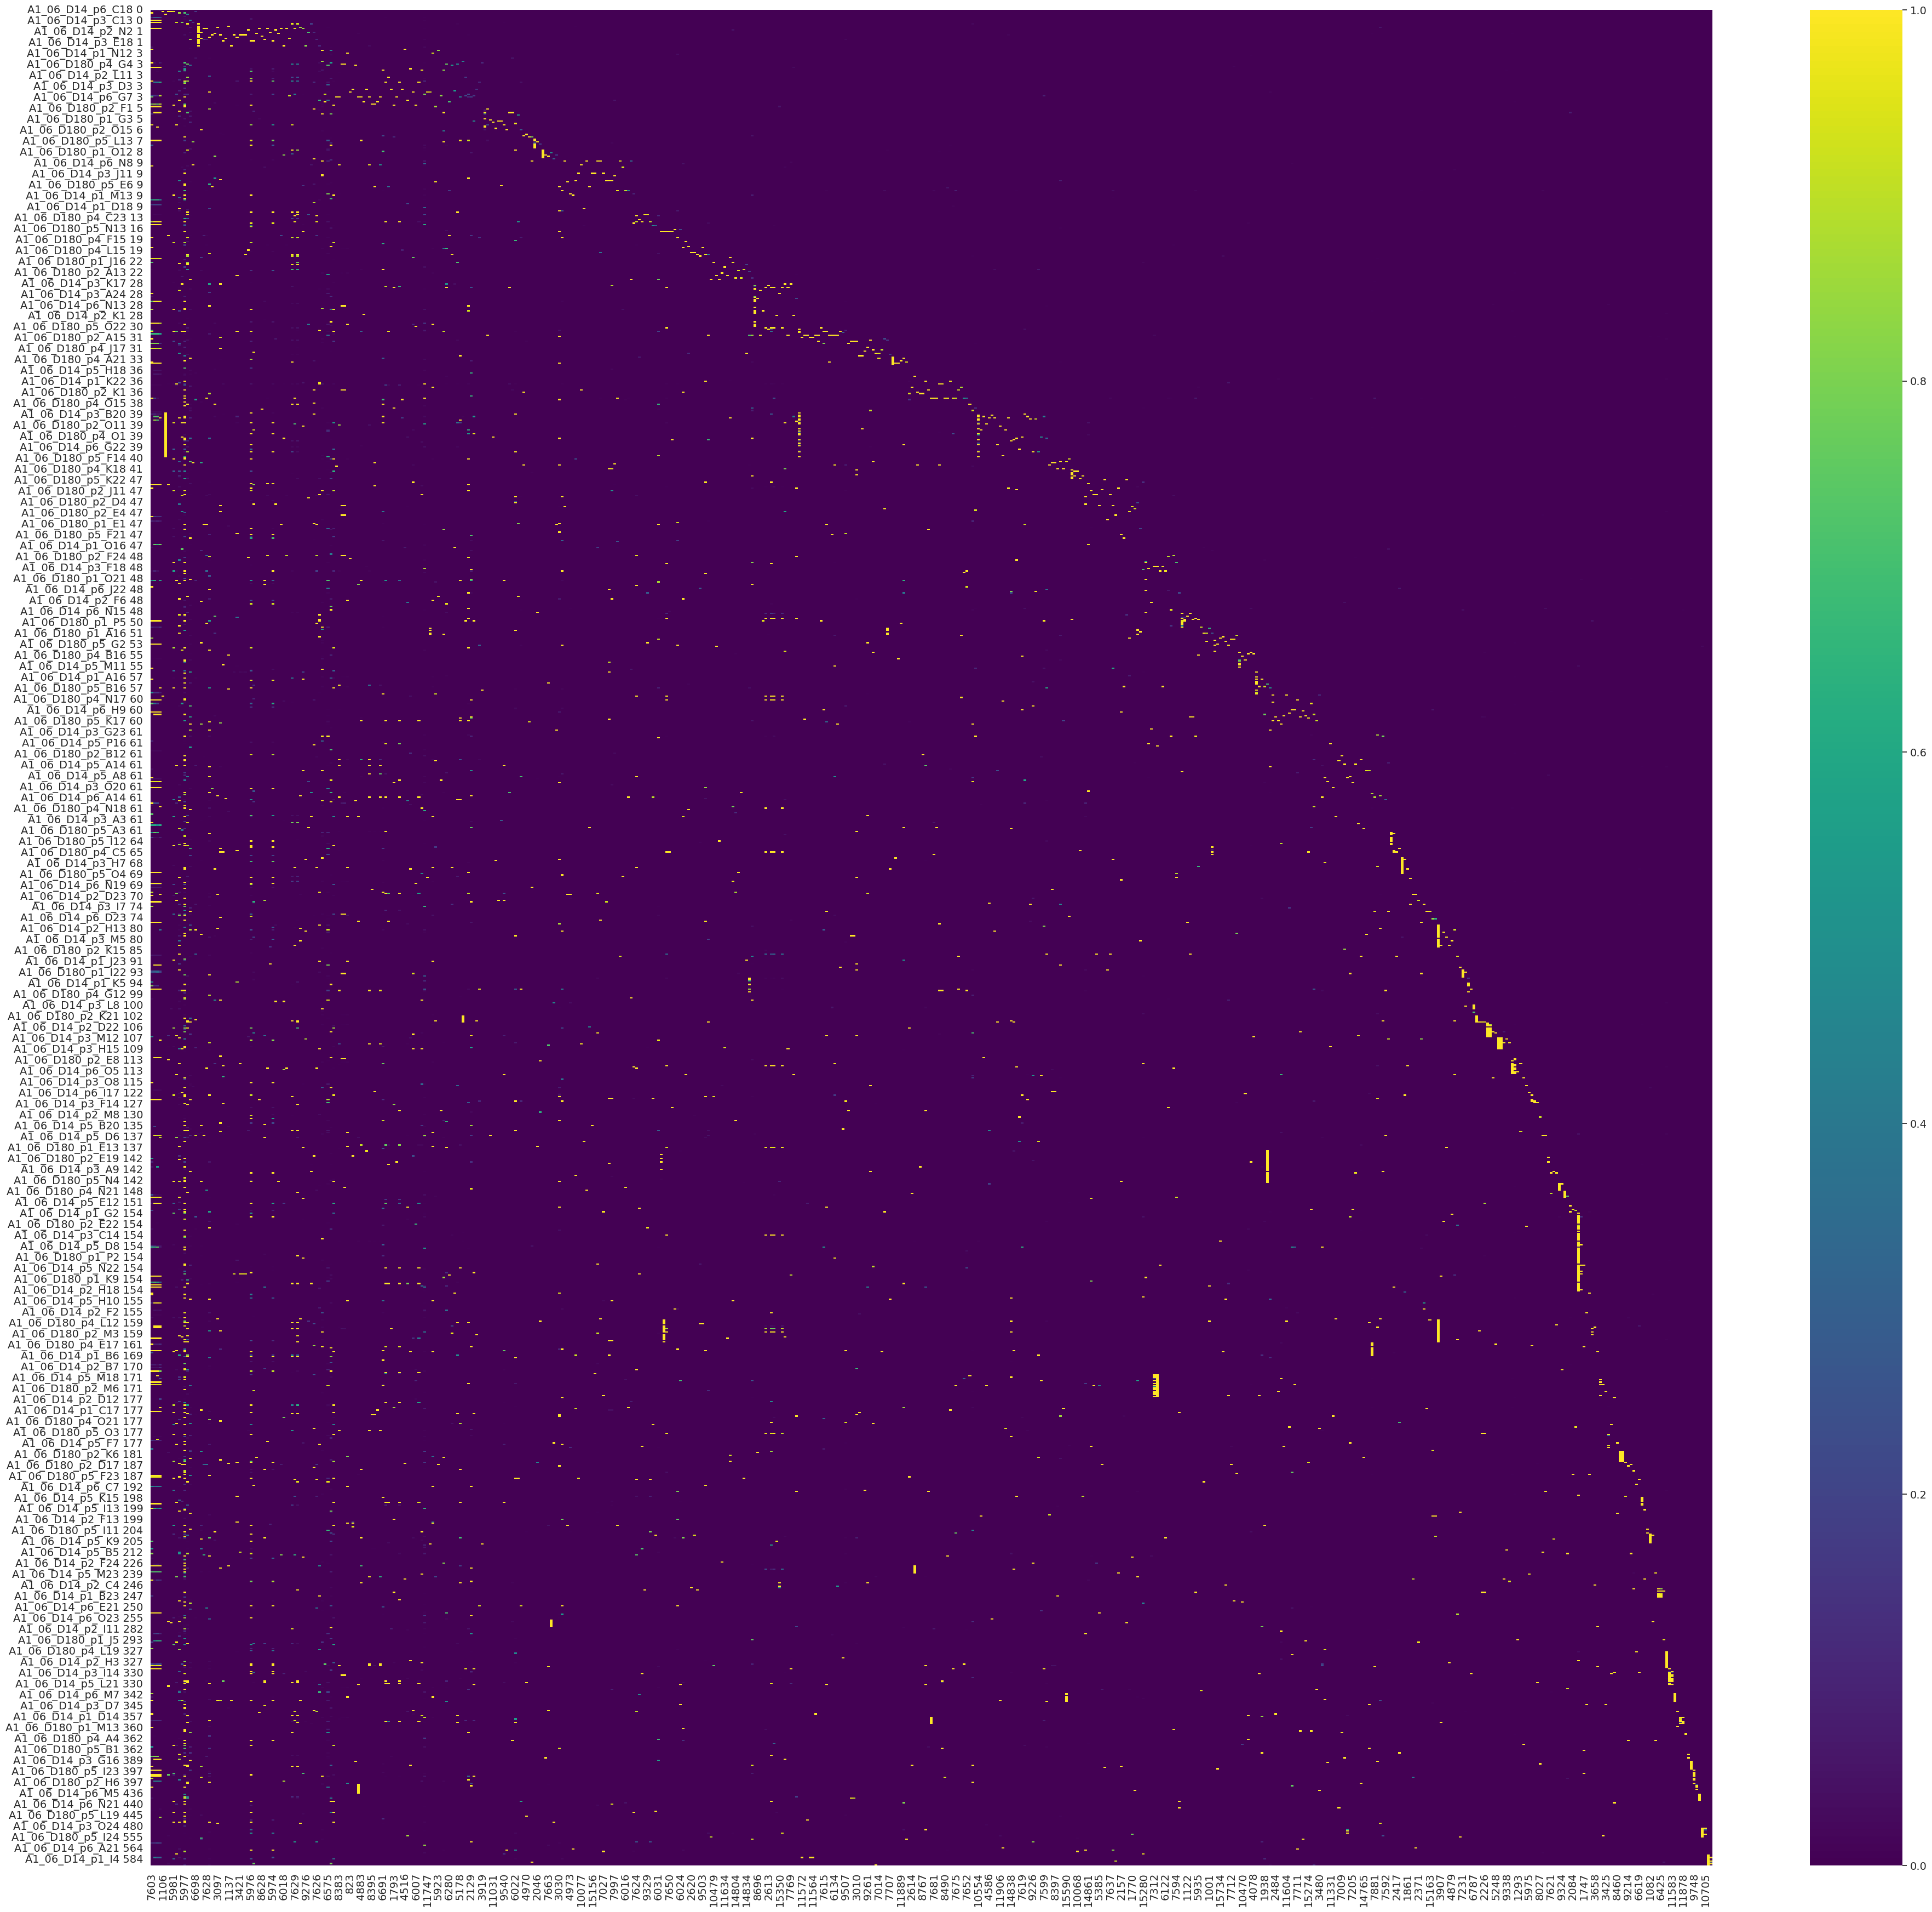

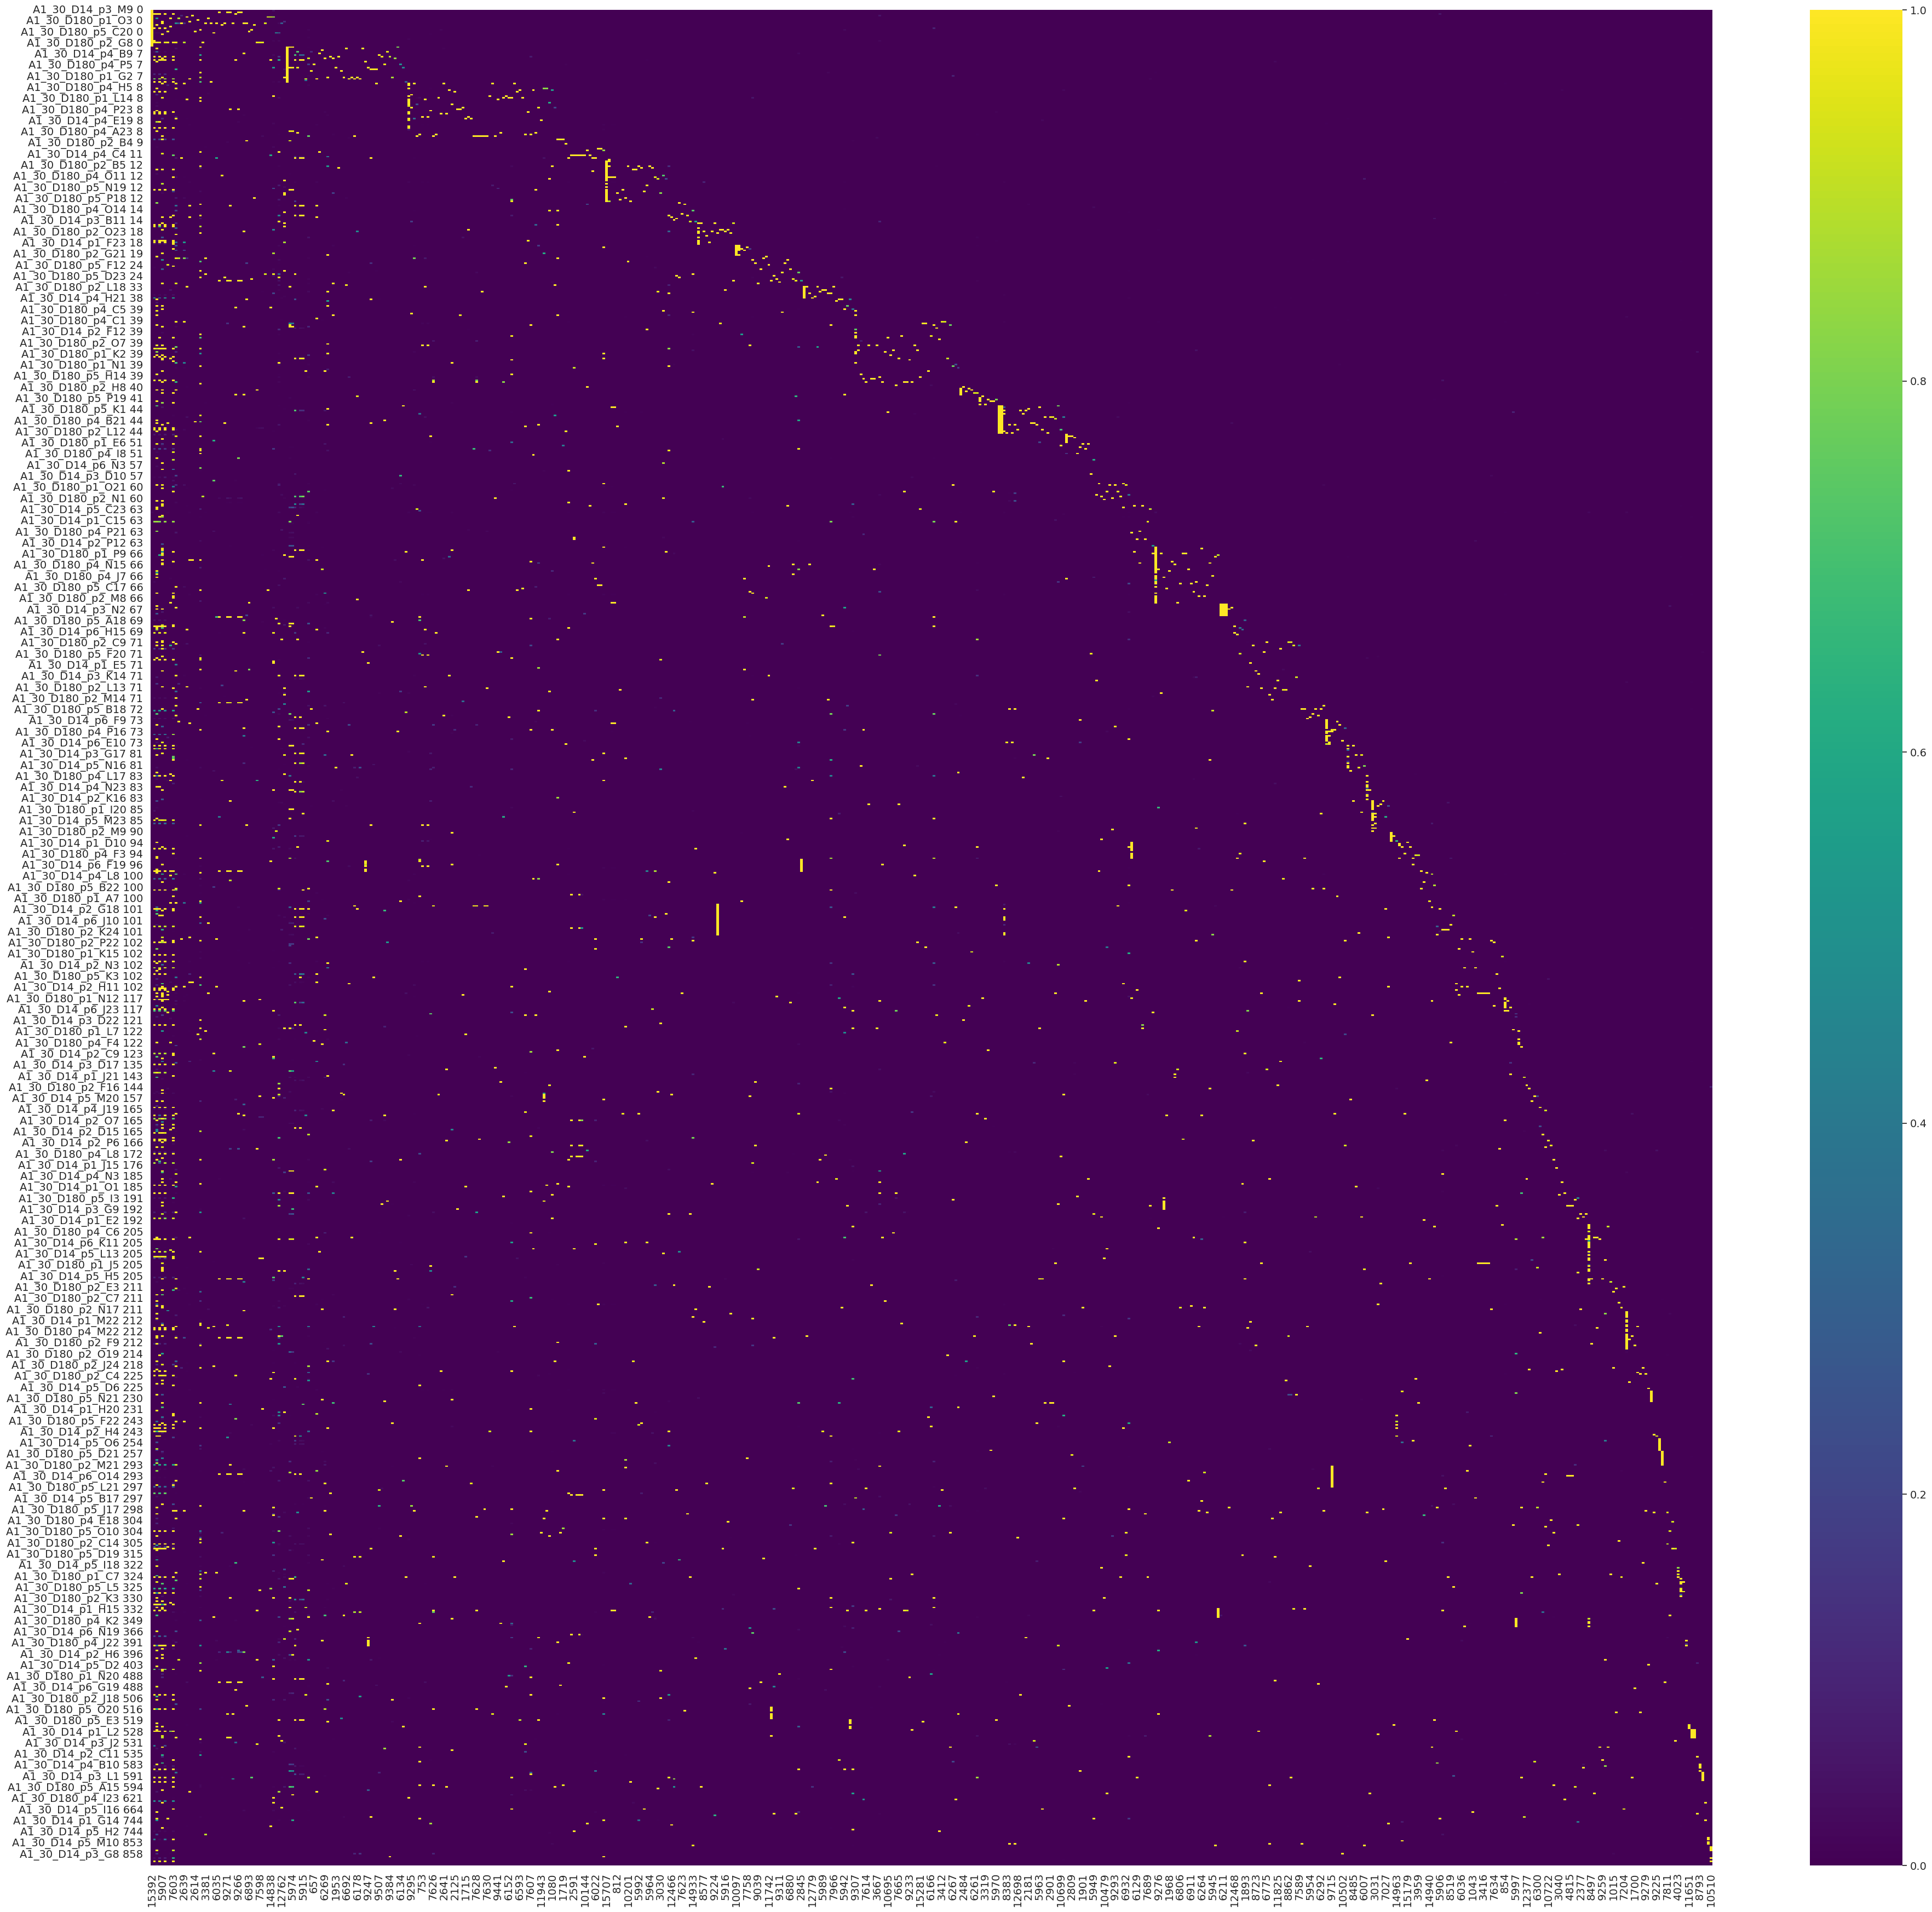

In [58]:
for donor in datasets:
    with plot_style(figsize=(46, 44)):
        sns.heatmap(plot_pmat[donor].T, cmap='viridis', linewidths=0.0)
        plt.xlabel('')
        plt.show()